# **Ciencia de Dados**

Dupla: Victor Ximenes e Pedro Nogueira

_link de onde foi extraido o dataset:_ _https://www.kaggle.com/datasets/nikdavis/steam-store-games_

## Bibliotecas

Autenticação para o databricks:

In [1]:
!databricks configure --host https://community.cloud.databricks.com/

Username: vxco@cin.ufpe.br
Password: 
Repeat for confirmation: 


Fazendo o download das bibliotecas e dos dados necessários

In [12]:
!pip install tensorflow
!pip install scipy
!pip install fancyimpute
!pip install mlflow --quiet
!pip install auto-sklearn
!pip install mlxtend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from fancyimpute import KNN
from numpy import log10
from numpy import abs
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns 
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score

#Linear model and lasso
from sklearn import linear_model

#Decision tree
from sklearn.tree import DecisionTreeRegressor

#SVR
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Random forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Auto sklearn
import autosklearn.regression

#MLFlow
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/vxco@cin.ufpe.br/SteamFlow")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1589124089079043', creation_time=1664823076963, experiment_id='1589124089079043', last_update_time=1664840657224, lifecycle_stage='active', name='/Users/vxco@cin.ufpe.br/SteamFlow', tags={'mlflow.experiment.sourceName': '/Users/vxco@cin.ufpe.br/SteamFlow',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vxco@cin.ufpe.br',
 'mlflow.ownerId': '600712814020203'}>

Carregamos o data frame que trabalhamos no projeto passado:

In [3]:
df_steam = pd.read_csv("https://raw.githubusercontent.com/nogsp/CienciaDeDados/main/NewSteam.csv")
df_steam = df_steam.drop(['Unnamed: 0' , 'name' , 'release_date' , 'developer' , 'publisher' , 'price_dist' , 'outlier'] , axis=1)#deixando apenas colunas numericas
df_steam

,achievements,positive_ratings,negative_ratings,owners,price,windows,mac,linux,multi_player,single_player,indie,action,casual,rpg,simulation,grade
0,0,3767,1053,3500000,0.00,1,1,1,0,1,0,1,0,0,0,78.153525
1,0,40,17,35000,5.99,1,0,0,1,1,1,0,0,0,0,70.175315
2,44,1562,223,750000,3.99,1,1,1,1,0,0,1,0,0,0,87.506998
3,0,468,61,150000,7.19,1,0,0,0,1,0,1,0,0,0,88.468792
4,0,472,158,750000,7.19,1,1,1,0,1,1,0,0,0,0,74.920623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26799,7,3,0,10000,2.09,1,0,0,0,1,1,0,1,0,0,99.996667
26800,0,8,1,10000,1.69,1,0,0,0,1,1,1,0,0,0,88.887901
26801,24,0,1,10000,3.99,1,0,0,1,1,1,1,1,0,0,0.000000
26802,0,2,0,10000,5.19,1,1,0,0,1,1,0,1,0,0,99.995000


Como podemos ver, retiramos as colunas que não nos interessam

## 1)Escolha de uma coluna para predição

Escolhemos a coluna ***grade*** para a predição, o método abaixo será usado para separar essa coluna para prediação

In [4]:
def make_label_data(df, column='grade'):
    label = df[column].copy()
    data = df.copy()
    data = data.drop([column] , axis=1)
    return {'data': data , 'label' : label}

##2)Separação dos dados em treinamento, validação e teste

Vamos dividir o dataset em treinameno, validação e teste, com 80%, 10% e 10% reespectivamente.

In [5]:
## A divisão será 80% treinamento, 10% validação e 10% teste
tamanho_total = len(df_steam)
split1 = int(0.8*tamanho_total)
split2 = int(0.9*tamanho_total)
#Separação
train_dataset = df_steam[:split1] #0% até 80%
validate_dataset = df_steam[split1:split2] #80% até 90%
test_dataset = df_steam[split2:] #90% até 100%
#Dropar coluna para criar data e label


treinamento = make_label_data(train_dataset)
validacao = make_label_data(validate_dataset)
teste = make_label_data(test_dataset)

## 3) Seleção de 4 algoritmos

Segue abaixo os algoritmos implementados para esse projeto:

### a) Linear Regression 

O algoritmo dessa técnica identifica uma relação linear entre a variavel alvo e as outras variaveis

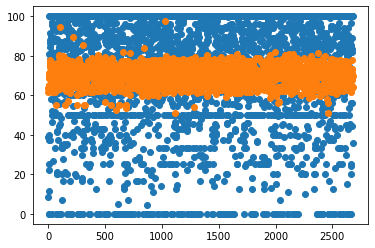

In [6]:
#Treinamento
modeloLinear = linear_model.LinearRegression(fit_intercept=True)
modeloLinear.fit(treinamento['data'], treinamento['label'])
#Validação 
pred = modeloLinear.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### b) Decision Tree Regression

O algoritmo dessa técnica funciona como uma árvore, onde os nós representam funcionalidades, cada ramo uma decisão e por fim as folhas simbolizando os resultados

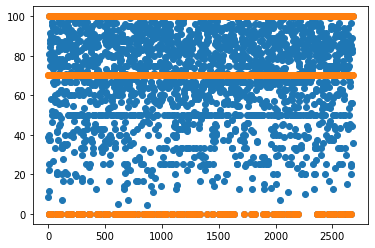

In [7]:

#Treinamento
modelo = DecisionTreeRegressor(max_depth=2)
modelo.fit(treinamento['data'], treinamento['label'])
#Validação
pred = modelo.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### c) ElasticNet Regression

Regressão regularizada que combina de forma linear as penalidades entre o método Lasso e Ridge

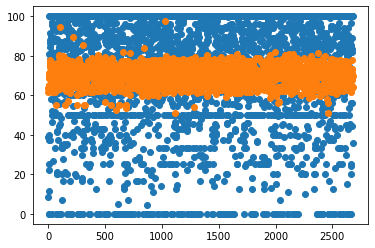

In [8]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
model.fit(treinamento['data'], treinamento['label'])
# Validação
pred = modeloLinear.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### d) Lasso Regression 

O algoritmo dessa técnica usa o encolhimento e seleção de variáveis ​​e ajuda a determinar quais dos preditores são mais importantes.

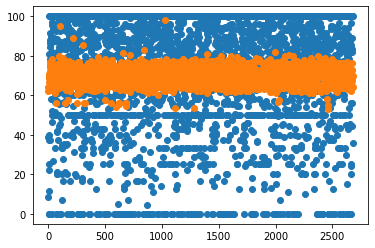

In [9]:

#Treinamento
modelo = linear_model.Lasso(alpha=0.1)
modelo.fit(treinamento['data'], treinamento['label'])
#Validação
pred = modelo.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### e) Random Forest Regressor (extra)

O algoritmo dessa técnica junta diversas decision tree's

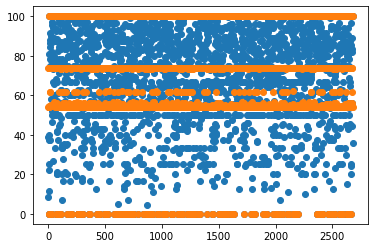

In [52]:

#Treinamento
modelo = RandomForestRegressor(max_depth=3)
modelo.fit(treinamento['data'], treinamento['label'])
#Validação
pred = modelo.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### f) Auto sklearn (extra)

Vai tentar achar a melhor solução para o problema

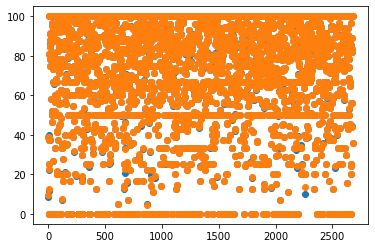

In [42]:

#Treinamento
modelo = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=120, per_run_time_limit=30, tmp_folder="/tmp/autosklearn_regression_example_tmp")
modelo.fit(treinamento['data'], treinamento['label'])
#Validação
pred = modelo.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

## 4) Adicionar MLFlow no treinamento para rastreamento

Criando função de gerar metricas

In [15]:
## Metrics 
def eval_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return rmse, mae , r2

Criando função que seleciona modelo e executa o treinamento

In [54]:
def create_train_model(tipo_modelo, trainset , evalset , args = []):
    #Definindo dataset
    train_x = trainset['data']
    train_y = trainset['label']
    eval_x = evalset['data']
    eval_y = evalset['label']

    #Seleçao do modelo
    if tipo_modelo == "Linear":
      inter = args[0]
      norm = args[1]
      model = linear_model.LinearRegression(fit_intercept= inter , normalize=norm)
    elif tipo_modelo == "DecisionTree":
      depth = args[0]
      model = DecisionTreeRegressor(max_depth=depth)
    elif tipo_modelo == 'ElasticNet':
      alpha = args[0]
      l1_ratio = args[1]
      model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    elif tipo_modelo == "Lasso":
      alpha = args[0]
      model = linear_model.Lasso(alpha=alpha)
    elif tipo_modelo == 'RandomForest':
      depth = args[0]
      model = RandomForestRegressor(max_depth=depth)
    elif tipo_modelo == 'AutoSklearn':
      model = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=120, per_run_time_limit=30, tmp_folder="/tmp/autosklearn_regression_example_tmp")
    mlflow.set_tag("mlflow.runName" , tipo_modelo)
    #Inicio do treinamento
    mlflow.end_run()
    with mlflow.start_run():
        #Train
        model.fit(train_x , train_y)

        #Pred
        predictions = model.predict(eval_x)

        (rmse , mae , r2) = eval_metrics(eval_y , predictions)
        print(tipo_modelo)
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        #Enviar parametros para rastreamento
        if tipo_modelo=="Linear":
          mlflow.log_param("intercept" , inter)
          mlflow.log_param("normalize" , norm)
        elif tipo_modelo == "DecisionTree":
          mlflow.log_param("max_depth" , depth)
        elif tipo_modelo == 'ElasticNet':
          mlflow.log_param("Alpha" , alpha)
          mlflow.log_param("L1_ratio" , l1_ratio)
        elif tipo_modelo == "Lasso":
          mlflow.log_param("alpha" , alpha)
        elif tipo_modelo == 'RandomForest': 
          mlflow.log_param("max_depth" , depth)

        #Enviar metricas para rastreamento
        mlflow.log_metric("rmse" , rmse) 
        mlflow.log_metric("mae" , mae)
        mlflow.log_metric("r2" , r2)

        #Enviar modelo para rastreamento com o nome do tipo
        mlflow.sklearn.log_model(model , tipo_modelo)
        mlflow.end_run()





In [22]:
parameters = [26]
create_train_model("RandomForest" , treinamento , validacao , parameters)

RandomForest
  RMSE: 0.16811117619525756
  MAE: 0.04539836592830936
  R2: 0.9999641721399463


## 5) Seleção de hiper-parametros

### a)Seleçao de 3 hiper-parametros por modelo

Otimização com Optuna

In [23]:
!pip install --quiet optuna

     |████████████████████████████████| 348 kB 40.3 MB/s 
     |████████████████████████████████| 81 kB 11.2 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 73.5 MB/s 
     |████████████████████████████████| 147 kB 74.5 MB/s 


In [24]:
import optuna
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
optuna.__version__

'3.0.2'

Optimize Decision Tree Regression 

In [25]:
def objective_Random_Decistion_Tree(trial):
      
      max= trial.suggest_int('max_depth', 1, 32)
      model = DecisionTreeRegressor(max_depth=max)

      score = cross_val_score(model, treinamento['data'], treinamento['label'], n_jobs=-1, cv=5).mean()
      return score

In [26]:
studyDecision = optuna.create_study(direction='maximize')
studyDecision.optimize(objective_Random_Decistion_Tree, n_trials=50)

[I 2022-10-04 00:02:36,058] A new study created in memory with name: no-name-cc6bcdc3-b34b-4c1c-8a39-0268b61852a0
[I 2022-10-04 00:02:38,302] Trial 0 finished with value: 0.9973231201170784 and parameters: {'max_depth': 27}. Best is trial 0 with value: 0.9973231201170784.
[I 2022-10-04 00:02:38,571] Trial 1 finished with value: 0.7926954346995979 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.9973231201170784.
[I 2022-10-04 00:02:38,936] Trial 2 finished with value: 0.991857725794941 and parameters: {'max_depth': 14}. Best is trial 0 with value: 0.9973231201170784.
[I 2022-10-04 00:02:39,371] Trial 3 finished with value: 0.9972862056398764 and parameters: {'max_depth': 21}. Best is trial 0 with value: 0.9973231201170784.
[I 2022-10-04 00:02:39,664] Trial 4 finished with value: 0.9056899373291147 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.9973231201170784.
[I 2022-10-04 00:02:40,097] Trial 5 finished with value: 0.9974376013467957 and parameters: {'

Optimize ElasticNet

In [27]:
def objective_Random_Elastic(trial):
      
      alpha= trial.suggest_int('alpha', 1, 32)
      l1_ratio = trial.suggest_float('l1_ratio' , 0.0 , 1.0)
      model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
      score = cross_val_score(model, treinamento['data'], treinamento['label'], n_jobs=-1, cv=5).mean()
      return score

In [28]:
studyElastic = optuna.create_study(direction='maximize')
studyElastic.optimize(objective_Random_Elastic, n_trials=100)

[I 2022-10-04 00:03:08,500] A new study created in memory with name: no-name-313cf94f-996c-42bb-8a44-10bb1420384f
[I 2022-10-04 00:03:08,765] Trial 0 finished with value: 0.06392180898390568 and parameters: {'alpha': 14, 'l1_ratio': 0.142548729932226}. Best is trial 0 with value: 0.06392180898390568.
[I 2022-10-04 00:03:08,980] Trial 1 finished with value: 0.06367467541081966 and parameters: {'alpha': 10, 'l1_ratio': 0.35923756134727514}. Best is trial 0 with value: 0.06392180898390568.
[I 2022-10-04 00:03:09,222] Trial 2 finished with value: 0.06401613845235692 and parameters: {'alpha': 5, 'l1_ratio': 0.5908022385392943}. Best is trial 2 with value: 0.06401613845235692.
[I 2022-10-04 00:03:09,367] Trial 3 finished with value: 0.0634605030376227 and parameters: {'alpha': 5, 'l1_ratio': 0.9844909619674167}. Best is trial 2 with value: 0.06401613845235692.
[I 2022-10-04 00:03:09,627] Trial 4 finished with value: 0.060737680015058707 and parameters: {'alpha': 19, 'l1_ratio': 0.49417828593

Optimize Lasso Regression

In [29]:
def objective_Random_Lasso(trial):
      
      alpha_estimators = trial.suggest_float('alpha' , 0.0 , 1.0)
      model = linear_model.Lasso(alpha=alpha_estimators)

      score = cross_val_score(model, treinamento['data'], treinamento['label'], n_jobs=-1, cv=5).mean()
      return score

In [30]:
studyLasso = optuna.create_study(direction='maximize')
studyLasso.optimize(objective_Random_Lasso, n_trials=100)

[I 2022-10-04 00:03:34,125] A new study created in memory with name: no-name-bc4a0c20-6966-4c6b-8247-579bdf529569
[I 2022-10-04 00:03:34,512] Trial 0 finished with value: 0.0951694979761637 and parameters: {'alpha': 0.20760751622126206}. Best is trial 0 with value: 0.0951694979761637.
[I 2022-10-04 00:03:34,846] Trial 1 finished with value: 0.07847192192465853 and parameters: {'alpha': 0.8030264007744411}. Best is trial 0 with value: 0.0951694979761637.
[I 2022-10-04 00:03:35,176] Trial 2 finished with value: 0.08950232555002968 and parameters: {'alpha': 0.46264122527513274}. Best is trial 0 with value: 0.0951694979761637.
[I 2022-10-04 00:03:35,500] Trial 3 finished with value: 0.0801143207360939 and parameters: {'alpha': 0.7575912077528563}. Best is trial 0 with value: 0.0951694979761637.
[I 2022-10-04 00:03:35,792] Trial 4 finished with value: 0.08067606918060319 and parameters: {'alpha': 0.741370042154625}. Best is trial 0 with value: 0.0951694979761637.
[I 2022-10-04 00:03:36,159]

Optimize Random Forest Regression

In [31]:
def objective_Random_Forest(trial):
      
      depth = trial.suggest_int('max_depth' , 1 , 32)
      model = RandomForestRegressor(max_depth=depth)

      score = cross_val_score(model, treinamento['data'], treinamento['label'], n_jobs=-1, cv=5).mean()
      return score

In [32]:
studyForest = optuna.create_study(direction='maximize')
studyForest.optimize(objective_Random_Forest, n_trials=50)

[I 2022-10-04 00:04:04,421] A new study created in memory with name: no-name-0b625ed2-b8cf-4481-8864-40ba8ac709b6
[I 2022-10-04 00:04:28,965] Trial 0 finished with value: 0.9992328669239706 and parameters: {'max_depth': 29}. Best is trial 0 with value: 0.9992328669239706.
[I 2022-10-04 00:04:46,840] Trial 1 finished with value: 0.9988744486406924 and parameters: {'max_depth': 15}. Best is trial 0 with value: 0.9992328669239706.
[I 2022-10-04 00:05:05,912] Trial 2 finished with value: 0.9992329475513004 and parameters: {'max_depth': 31}. Best is trial 2 with value: 0.9992329475513004.
[I 2022-10-04 00:05:27,525] Trial 3 finished with value: 0.9992205431254181 and parameters: {'max_depth': 27}. Best is trial 2 with value: 0.9992329475513004.
[I 2022-10-04 00:05:50,808] Trial 4 finished with value: 0.9992524696325482 and parameters: {'max_depth': 24}. Best is trial 4 with value: 0.9992524696325482.
[I 2022-10-04 00:06:17,296] Trial 5 finished with value: 0.9992526292866983 and parameters:

### Salvar parametros e acuracia 

In [33]:
trialDecision = studyDecision.best_trial
trialElastic = studyElastic.best_trial
trialLasso = studyLasso.best_trial
trialForest = studyForest.best_trial

### b) Seleção do melhor modelo 

In [34]:
def eval_best_Decision(trial):
    #Best parameters
    max = trial.params['max_depth']
    #Treinamento
    modelo = DecisionTreeRegressor(max_depth=max)
    modelo.fit(treinamento['data'], treinamento['label'])
    #Validação
    pred = modelo.predict(validacao['data'])
    true = validacao['label']
    #Metricas
    (rmse , mae , r2) = eval_metrics(true , pred)
    print("Decision Tree Regression:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("----------------------\n")


In [35]:
def eval_best_Elastic(trial):
    #Best parameters
    alpha = trial.params['alpha']
    l1_ratio = trial.params['l1_ratio']
    #Treinamento
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    modelo.fit(treinamento['data'], treinamento['label'])
    #Validação
    pred = modelo.predict(validacao['data'])
    true = validacao['label']
    #Metricas
    (rmse , mae , r2) = eval_metrics(true , pred)
    print("ElasticNet Regression:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("----------------------\n")


In [36]:
def eval_best_Lasso(trial):
    #Best parameters
    alpha = trial.params['alpha']
    
    #Treinamento
    modelo = linear_model.Lasso(alpha=alpha)
    modelo.fit(treinamento['data'], treinamento['label'])
    #Validação
    pred = modelo.predict(validacao['data'])
    true = validacao['label']
    #Metricas
    (rmse , mae , r2) = eval_metrics(true , pred)
    print("Lasso Regression:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("----------------------\n")

In [37]:
def eval_best_Forest(trial):
    #Best parameters
    depth = trial.params['max_depth']
    #Treinamento
    modelo = RandomForestRegressor(max_depth=depth)
    modelo.fit(treinamento['data'], treinamento['label'])
    #Validação
    pred = modelo.predict(validacao['data'])
    true = validacao['label']
    #Metricas
    (rmse , mae , r2) = eval_metrics(true , pred)
    print("Random Forest Regression:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("----------------------\n")

In [44]:
def eval_best_AutoSklearn():
    #Treinamento
    modelo = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=120, per_run_time_limit=30, tmp_folder="/tmp/autosklearn_regression_example_tmp")
    modelo.fit(treinamento['data'], treinamento['label'])
    #Validação
    pred = modelo.predict(validacao['data'])
    true = validacao['label']
    #Metricas
    (rmse , mae , r2) = eval_metrics(true , pred)
    print("Auto sklearn Regression:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("----------------------\n")

Agora, fazer a chamada de cada função de metrica para executar ver os erros e ver qual modelo tem o melhor desempenho, além disso enviamos esses valores para o mlflow para poder observar de forma melhor.

In [55]:
#Decision Tree Regression
parameters = [trialDecision.params['max_depth']]
create_train_model("DecisionTree" , treinamento , validacao , parameters)
#ElascticNet Regression
parameters = [trialElastic.params['alpha'] , trialElastic.params['l1_ratio']]
create_train_model("ElasticNet" , treinamento , validacao , parameters)
#Lasso Regression
parameters = [trialLasso.params['alpha']]
create_train_model("Lasso" , treinamento , validacao , parameters)
#Random Forest Regression
parameters = [trialForest.params['max_depth']]
create_train_model("RandomForest" , treinamento , validacao , parameters)
#Auto Sklearn
create_train_model("AutoSklearn" , treinamento , validacao , None)

DecisionTree
  RMSE: 0.4139519505183334
  MAE: 0.09823497105060089
  R2: 0.9997827661184229
ElasticNet
  RMSE: 27.759601442992242
  MAE: 22.526184030258566
  R2: 0.023090914538340446
Lasso
  RMSE: 27.503634418471123
  MAE: 22.256008663459117
  R2: 0.041023711303109445
RandomForest
  RMSE: 0.18564839719745252
  MAE: 0.04586431780531607
  R2: 0.999956307177158


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


AutoSklearn
  RMSE: 0.19254381595983427
  MAE: 0.07004210602310067
  R2: 0.9999530011918091


Segue abaixo um print dos modelos gerados pelo ***mlflow***:

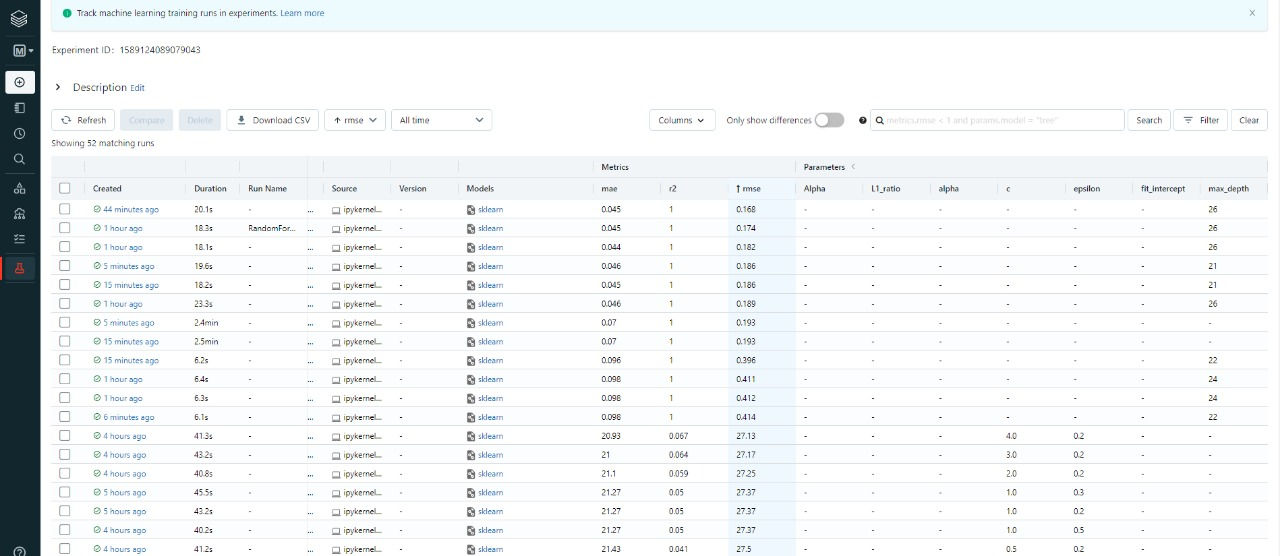

O melhor modelo observado foi o ***Random Forest***

Note que pelos graficos iniciais na sessão 3 temos a impressão que o auto sklearn é bem melhor que o random forest, mas isso é por que naquele momento, não tinhamos escolhido o melhor hiper-parâmetro, segue abaixo o gráfico para o random forest otimizado:

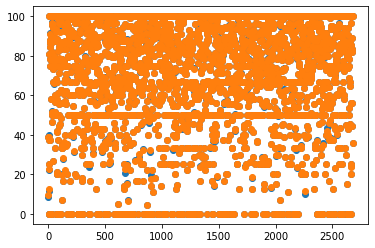

In [53]:

#Treinamento
modelo = RandomForestRegressor(max_depth=26)
modelo.fit(treinamento['data'], treinamento['label'])
#Validação
pred = modelo.predict(validacao['data'])
true = validacao['label']
xlabel = [i for i in range(len(validacao['label']))]

#True
plt.scatter(xlabel , true)
#Pred
plt.scatter(xlabel , pred)

### c) Execução do melhor modelo no conjunto teste

In [50]:
depth = trialForest.params['max_depth']
#Treinamento
modelo = RandomForestRegressor(max_depth=depth)
modelo.fit(treinamento['data'], treinamento['label'])
#Teste 
pred = modelo.predict(teste['data'])
true = teste['label']
#Metricas
(rmse , mae , r2) = eval_metrics(true , pred)
print("Random Forest Regression:")
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)
print("----------------------\n")


Random Forest Regression:
  RMSE: 0.09791352528406154
  MAE: 0.02368519556889908
  R2: 0.9999884933319558
----------------------



## 6) Diagnóstico do melhor modelo

Vamos tentar identificar se ocorreu algum overfit ou underfit, para isso vamos analisar o resultado do modelo predizindo o dataset de teste e de treino

In [75]:
from sklearn.metrics import mean_absolute_percentage_error

pred = modelo.predict(teste['data'])
test_error = mean_absolute_percentage_error(teste['label'], pred)
bias = np.mean(pred - teste['label'])

pred = modelo.predict(treinamento['data'])
train_error = mean_absolute_percentage_error(treinamento['label'], pred)


print("Test Error: {:.3F}%%".format((test_error*100)))
print("Train Error: {:.3F}%%".format((train_error*100)))
print("Variance: {:.3F}%%".format(abs(test_error - train_error)))
print("Bias: {:.3F}%%".format(bias))


Test Error: 0.054%%
Train Error: 0.124%%
Variance: 0.001%%
Bias: -0.001%%


Por esses resultados vemos que o modelo tem um erro muito baixo tanto para o dataset de treinamento quanto para o de teste, além disso possui uma variancia muito baixa entre eles, mostrando que não há muita diferença de performance entre um dataset conhecido ou não. Além disso vemos que o bias está muito próximo de zero, indicando que não há nem overfit nem underfit além de resultados ótimos.